# 🎓 Final Exam – Developing Notebook (Introduction to ML)

**Duration (suggested):** 120 minutes  
**Environment:** CPU-only; Python 3.8+; `numpy`, `pandas`, `matplotlib`, `scikit-learn`

## Instructions
- Sections build toward an end-to-end workflow.
- Respect provided function names / signatures for the quick checks.
- Use `RANDOM_STATE` for reproducibility.
- Include short written reflections in Markdown where asked.

## 📦 Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

## A. Conceptual (Short Answers)

### A1. Classical ML vs Deep Learning
**Q:** In 4–6 sentences, compare classical ML and deep learning in terms of feature engineering, data requirements, and interpretability.


**A:**


 Classical machine learning typically relies on manual feature engineering, where humans design the input features, while deep learning automatically learns features from raw data. Because of this automation, deep learning generally requires much larger datasets to perform well, whereas classical ML can work effectively with smaller, well-crafted features. Deep learning models, especially large neural networks, tend to behave like “black boxes,” making their decisions harder to interpret. Classical ML models—like decision trees, linear models, and SVMs—are usually more transparent and easier to explain. Overall, deep learning excels with complex, high-dimensional data, while classical ML is often preferred when data is limited or interpretability is important.

### A2. Attention (Seq2Seq)
**Q:** Briefly explain how attention helps a seq2seq model handle long sequences.

**A:**

Attention helps a seq2seq model handle long sequences by letting the decoder directly “look at” any part of the encoder’s outputs instead of relying only on a single fixed-length context vector. This means the model can focus on the most relevant tokens at each decoding step, reducing information loss from long inputs. As a result, attention improves accuracy, especially for long or complex sequences, by dynamically weighting important encoder states.


## B. Case Design
You are given a binary classification problem (predicting churn). You will:
1. Prepare the data pipeline
2. Train & tune models
3. Evaluate and interpret results

### B1. Data Generation
We'll simulate a small, noisy dataset with mixed types to mimic a real use case.

In [2]:
# Simulate numerical data
X_num, y = make_classification(
    n_samples=1200, n_features=8, n_informative=5, n_redundant=1, n_repeated=0,
    n_clusters_per_class=2, weights=[0.6, 0.4], class_sep=1.2, flip_y=0.03,
    random_state=RANDOM_STATE
)

# Add 2 categorical features by binning / hashing
num_df = pd.DataFrame(X_num, columns=[f"num_{i}" for i in range(X_num.shape[1])])

# Create synthetic categoricals
cat_1 = pd.qcut(num_df["num_0"], q=4, labels=["A","B","C","D"]).astype(str)
cat_2 = pd.cut(num_df["num_1"], bins=3, labels=["Low","Med","High"]).astype(str)

df = num_df.copy()
df["cat_1"] = cat_1
df["cat_2"] = cat_2
df["target"] = y

# Introduce a few missing values
for col in ["num_2", "num_5", "cat_2"]:
    idx = np.random.choice(df.index, size=40, replace=False)
    df.loc[idx, col] = np.nan

df.head()

,num_0,num_1,num_2,num_3,num_4,num_5,num_6,num_7,cat_1,cat_2,target
0,-0.607675,-0.679645,1.246789,-2.830948,2.907636,0.018243,-0.833160,-1.530621,B,Med,0
1,0.336990,1.146102,-0.613989,2.064200,3.114375,-0.269409,3.270021,1.869730,C,Med,1
2,-0.123263,-4.052319,-1.407661,1.597107,-2.585870,0.173368,4.604598,4.340083,B,Low,1
3,-0.242874,-2.408749,-0.484409,0.669634,2.017561,1.440182,3.644607,1.255033,B,Low,1
4,0.521732,1.121172,1.717128,-2.707218,-0.991357,0.629626,-3.596992,-1.197336,C,Med,0


### B2. Train/Validation/Test Split
- Use 60%/20%/20% split (train/val/test).  
- Maintain class balance with `stratify`.

In [5]:
X = df.drop(columns=["target"])
y = df["target"].values

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE, stratify=y_trainval
)  # 0.25 * 0.8 = 0.2

X_train.shape, X_val.shape, X_test.shape

((720, 10), (240, 10), (240, 10))

### B3. Preprocessing Pipelines
- Numerical: impute median, scale  
- Categorical: impute most_frequent, one-hot encode  
- Models: Logistic Regression and Random Forest (compare)

In [8]:
num_features = [c for c in X.columns if c.startswith("num_")]
cat_features = ["cat_1", "cat_2"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

pipe_lr = Pipeline(steps=[("preprocess", preprocess),
                         ("clf", LogisticRegression(max_iter=200, random_state=RANDOM_STATE))])

pipe_rf = Pipeline(steps=[("preprocess", preprocess),
                         ("clf", RandomForestClassifier(random_state=RANDOM_STATE))])

pipe_lr, pipe_rf

(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['num_0', 'num_1', 'num_2',
                                                    'num_3', 'num_4', 'num_5',
                                                    'num_6', 'num_7']),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('ohe',
         

### B4. Hyperparameter Tuning (Validation Set)
Use `GridSearchCV` for each model with a **small** grid. Optimize for ROC-AUC.  
Compare the best parameters and validation performance.

In [10]:
param_lr = {"clf__C": [0.1, 1.0, 3.0]}
param_rf = {"clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 6, 10]}

grid_lr = GridSearchCV(pipe_lr, param_grid=param_lr, scoring="roc_auc",
                       cv=3, n_jobs=-1)
grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, scoring="roc_auc",
                       cv=3, n_jobs=-1)

grid_lr.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

print("Best LR params:", grid_lr.best_params_, "AUC:", round(grid_lr.best_score_, 4))
print("Best RF params:", grid_rf.best_params_, "AUC:", round(grid_rf.best_score_, 4))

Best LR params: {'clf__C': 0.1} AUC: 0.9676
Best RF params: {'clf__max_depth': 10, 'clf__n_estimators': 200} AUC: 0.9781


### B5. Evaluate on Validation & Test
Pick the better model on **validation** (AUC) and evaluate on **test**.  
Report Confusion Matrix, ROC-AUC, and a brief interpretation.

Test ROC-AUC: 0.9655


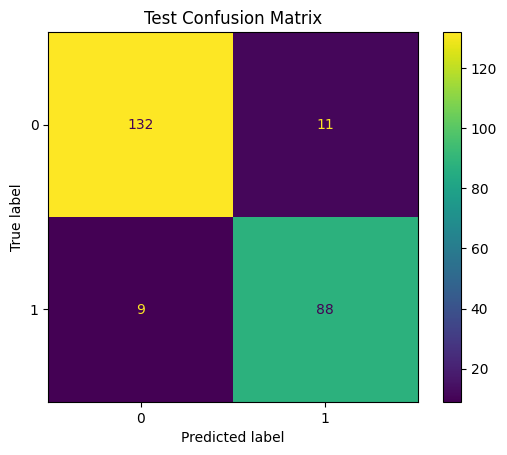

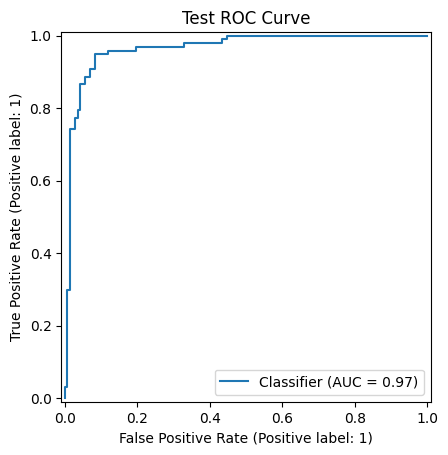

In [12]:
best_model = grid_rf if grid_rf.best_score_ >= grid_lr.best_score_ else grid_lr

X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([y_train, y_val])

best_model.best_estimator_.fit(X_trval, y_trval)

y_proba = best_model.best_estimator_.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("Test ROC-AUC:", round(auc, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Test Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Test ROC Curve")
plt.show()

### B6. Short Reflection
In 4–6 sentences:  
- Which model performed better and why might that be?  
- Which metric is most appropriate here and why?  
- How would class imbalance change your approach?

*Your reflection:*

Random Forest performed better with a validation AUC of 0.9781 compared to Logistic Regression's 0.9676. This difference, although small, suggests that Random Forest, being a non-linear ensemble model, was better able to capture complex relationships within the data. Logistic Regression, a linear model, might not have been as effective in modeling the underlying patterns.

For this churn prediction problem, ROC-AUC is a highly appropriate metric because it evaluates the model's ability to distinguish between classes across all possible classification thresholds. It is especially useful when the costs of false positives and false negatives are unknown or varying, or when class distributions are imbalanced. For a business context like churn, identifying potential churners (positives) is crucial, and ROC-AUC provides a comprehensive view of this capability.

If class imbalance were significant, my approach would change in several ways. Firstly, accuracy would become an unreliable metric, and I would rely more heavily on metrics like precision, recall, F1-score, and ROC-AUC. Secondly, I would consider sampling techniques such as oversampling the minority class (e.g., SMOTE) or undersampling the majority class during training. Finally, I might explore models inherently more robust to imbalance, or use cost-sensitive learning techniques where misclassifying the minority class incurs a higher penalty.

## C. Ethics & Deployment (Short Answer)

### C1. Bias & Fairness
**Q:** Describe two ways to detect potential bias in a classification model and one mitigation technique.

**A:**

Two ways to detect potential bias in a classification model are:
1.  **Disparate Impact Analysis:** Compare model performance metrics (e.g., accuracy, precision, recall, F1-score) across different demographic groups (e.g., race, gender, age). Significant differences in these metrics for protected groups could indicate bias. For instance, if a model consistently has lower recall for a minority group, it might be biased against that group.
2.  **Feature Importance and Association:** Analyze which features the model relies on most heavily for its predictions and if any of these features are proxies for sensitive attributes. Tools like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) can help identify feature contributions to individual predictions or overall model behavior. If sensitive attributes or their proxies are highly influential, it suggests potential bias.

One mitigation technique is:
**Fairness-Aware Data Preprocessing:** This involves adjusting the training data before model training to reduce existing biases. Techniques include re-weighting samples, re-sampling to balance representation of protected groups, or suppressing sensitive attributes directly or indirectly. For example, using methods like **Reweighing** or **Disparate Impact Remover** from fairness toolkits can balance the dataset with respect to sensitive attributes and target outcomes, thereby reducing the model's ability to learn biased patterns.


### C2. Minimal Deployment Thought Exercise
**Q:** You need to deploy the chosen model as a REST endpoint. List the minimal components (data validation, versioning, monitoring) you would include to ensure reliability.

**A:**

For a minimal reliable REST endpoint deployment of a machine learning model, I would include the following components:

**Data Validation:**

1. Schema Enforcement: Implement checks to ensure incoming request payloads conform to the expected data schema (e.g., correct data types, required fields present, valid ranges for numerical features, expected categories for categorical features). This prevents malformed requests from reaching the model.

2. Feature Compatibility: Verify that the features in the incoming request match the features the model was trained on, including order and format. This ensures the preprocessing steps and the model itself receive data in the format they expect.

**Versioning:**

1. API Versioning: Use URL path versioning (like /api/v1/predict, /api/v2/predict) or header versioning to allow for backward compatibility and simultaneous operation of different API versions.

2. **Model Versioning**: Manage different trained model artifacts, each with a unique identifier. The API endpoint would then reference a specific model version, allowing for seamless updates or rollbacks without affecting clients using older API versions. A model registry would be essential here.

**Monitoring:**

1. API Performance Monitoring: Track response times, error rates , and request throughput to ensure the service is responsive and stable.

2. Model Performance Monitoring: Continuously monitor the model's predictive performance (e.g., accuracy, ROC-AUC, precision, recall) on live data, comparing it against a baseline or a human-in-the-loop system. This helps detect model degradation or drift.

3. Data Drift Detection: Monitor the statistical properties of incoming live data compared to the training data. Significant shifts can indicate concept drift or issues with data collection pipelines, which might need model retraining.

4. Resource Utilization: Track CPU, memory, and network usage of the deployment environment to ensure efficient operation and scale as needed.



## ✅ Final Checklist
- [ ] All cells run without error
- [ ] All requested plots produced
- [ ] Reflections written
- [ ] Decisions supported by metrics